# 版权声明

版权 © 2023 斯坦福大厨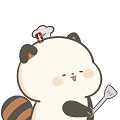，华中科技大学微纳材料设计与制造研究中心的科研工作者。

恭喜您已经发现了这份神奇的计算材料学课件！这份课件是我在熬夜吃掉不计其数的披萨和咖啡后创作出来的，配套的教材是由单斌、陈征征、陈蓉合著的《计算材料学-从算法原理到代码实现》。学习资料合集您可以在这个网址找到：[www.materialssimulation.com/book](www.materialssimulation.com/book)。希望它能帮您在计算材料学的道路上摔得不那么痛。

就像您尊重那些一边烘焙披萨一边写代码的大厨一样，当您使用这份课件时，请：

- 记得告诉大家这份课件是斯坦福大厨写的，并且他在华中科技大学微纳中心工作
- 别用它去赚大钱，这个课件是用来学习的，不是用来买披萨的
- 保持开放共享的精神

如果你有关于计算材料学的想法，或者你只是想和我讨论最好吃的披萨口味，欢迎通过邮件 bshan@mail.hust.edu.cn 联系我。
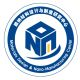

## 1. 一维谐振子运动方程

在这个notebook里，我们将用verlet算法对于一维谐振子的运动进行积分。由于一维谐振子有解析解，所以我们可以将数值积分的结果与解析形式相比对，从而对误差积累，算法稳定性等有一个直观的认识。一维谐振子的解析解如下：

1. 位置:

   $x(t) = x_0 \cos(wt) + \frac{v_0}{w} \sin(wt)$

2. 速度:

   $v(t) = -x_0 w \sin(wt) + v_0 \cos(wt)$

where,
$w = \sqrt{\frac{k}{m}}$


我们首先定义一个HarmonicOscillator的类，用于描述谐振子：

In [16]:
import numpy as np

class HarmonicOscillator:
    def __init__(self, k, m):
        self.k = k
        self.m = m

    def acceleration(self, x):
        return -self.k * x / self.m

    def analytical_solution(self, x0, v0, t):
        """
        Calculate the analytical solution for the 1D harmonic oscillator.

        Parameters:
        x0 : float
            Initial position.
        v0 : float
            Initial velocity.
        t : float
            Time at which to calculate the position and velocity.

        Returns:
        x : float
            Position at time t.
        v : float
            Velocity at time t.
        """
        w = np.sqrt(self.k / self.m)  # angular frequency
        x = x0 * np.cos(w*t) + v0/w * np.sin(w*t)
        v = -x0 * w * np.sin(w*t) + v0 * np.cos(w*t)
        return x, v


我们可以用这样的方法来创建一个HarmonicOscillator实例，它的acceleration函数会告诉你谐振子处在位置x处的加速度

In [17]:
# Set up the system
k = 1.0  # spring constant
m = 1.0  # mass
oscillator = HarmonicOscillator(k, m)
oscillator.acceleration(1.0)

-1.0

### 2. Leapfrog积分器

Leapfrog积分算法是一种常见的用于求解二阶常微分方程的数值方法，特别适用于物理系统的模拟，如分子动力学和天体力学。Leapfrog积分算法的名字来源于其更新位置和速度的方式，这两个变量在时间步上像青蛙跳跃般交错，即在相同的时间步，位置和速度的更新是分开的，这也是Leapfrog算法的一个显著特点。

Leapfrog积分算法的主要优点是它的精度和稳定性。这是因为Leapfrog算法是一个对称的、可逆的算法，这种性质使得在进行物理模拟时，它能很好的保持系统的能量守恒。

然而，Leapfrog积分算法也有一些缺点。对于某些问题，比如处理粘性力或者摩擦力的问题，可能会有一些困难。Leapfrog积分算法在许多物理模拟中都被广泛使用，因为它的简单性、精度和稳定性。


接下来我们将Leapfrog积分算法封装在LeapfrogIntegrator类里，算法的时间更新步如下：


$$r(t + dt) = r(t) + v(t+dt/2)*dt$$

$$v(t + dt/2) = v(t-dt/2) + \frac{F(t)}{m} * dt$$


Leapfrog基本的算法过程如下图所示：


In [18]:
class LeapfrogIntegrator:
    """
    LeapfrogIntegrator is a class for the Leapfrog integration method.

    Attributes:
        dt: The timestep for integration.

    Methods:
        step(system, x, v): Perform one step of Leapfrog integration.
    """
    def __init__(self, dt):
        self.dt = dt

    def step(self, system, x, v):
        """
        Parameters:
        x : float
            current position
        v : float
            velocity at current minus half timestep

        Returns:
        x_next : float
            position at next time step
        v_next : float
            velocity at next half timestep
        """
        a = system.acceleration(x)
        v_next = v + 0.5 * self.dt * a
        x_next = x + self.dt * v_next
        return x_next, v_next


## 3. 用Leapfrog积分方法求解一维谐振子运动

我们首先定义一个用于可视化轨迹的plot_results函数

In [19]:
import matplotlib.pyplot as plt

def plot_results(times, positions, velocities):
    """
    Plot the time evolution of position and phase space trajectory.

    This function generates two subplots: one showing the position as a function
    of time, and one showing the phase space trajectory (velocity vs. position).

    Parameters:
    times : list of float
        List of times at which the position and velocity were recorded.
    positions : list of float
        List of positions of the harmonic oscillator at the corresponding times.
    velocities : list of float
        List of velocities of the harmonic oscillator at the corresponding times.

    Returns:
    None
    """

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(times, positions)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_title('Time Evolution of Position')

    plt.tight_layout()
    plt.show()


接下来我们用dt=0.01的步长进行1000步的Leapfrog积分运算

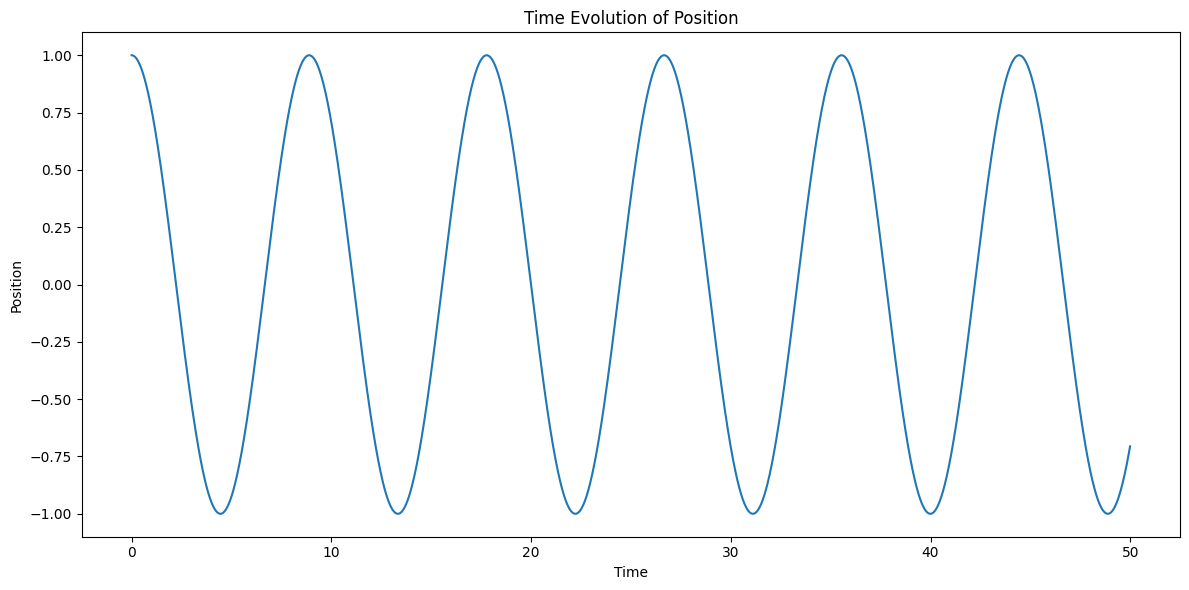

In [20]:
import math

def main():
    # Set up the system
    k = 1.0  # spring constant
    m = 1.0  # mass
    oscillator = HarmonicOscillator(k, m)

    # Set up the integrator
    dt = 0.01  # time step
    integrator = LeapfrogIntegrator(dt)

    # Initial conditions
    x0 = 1.0  # initial position
    v0 = 0.0  # initial velocity

    # Lists to store time, positions, and velocities
    times = []
    positions = []
    velocities = []

    # Get velocity at -dt/2 timestep
    x = x0
    v = v0 - 0.5 * dt * oscillator.acceleration(x0)

    # Time evolution
    for i in range(5000):
        times.append(i * dt)
        positions.append(x)
        velocities.append(v)
        x, v = integrator.step(oscillator, x, v)


    plot_results(times, positions, velocities)

if __name__ == "__main__":
    main()


上图展示了一维谐振子的位置和速度随时间变化的图像，leapfrog算法表现出了很好的稳定性。